# Lesson 7: Classification

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

We will use the Kaggle Titanic data to demonstrate these major steps.
- Data: https://www.kaggle.com/competitions/titanic/data
- Examples used to compose this notebook: https://www.kaggle.com/code/startupsci/titanic-data-science-solutions

In [2]:
# Import data from Kaggle Competition
PATH = "./data/titanic"
df = pd.read_csv(os.path.join(PATH, "train.csv"), index_col=0)
df.drop(["Cabin"], axis=1, inplace=True)  # Видаляє зі DataFrame 'df' стовпець з назвою "Cabin"
df.dropna(subset=["Embarked"], inplace=True)  # Видаляє з DataFrame всі рядки, у яких у стовпці 'Embarked' є пропущені значення (NaN)

df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S


In [3]:
# train-test-split
df_train, df_test = train_test_split(df, test_size=0.15, random_state=42, shuffle=True)
combine = [df_train, df_test]

df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [4]:
for dataset in combine:
    dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  755 non-null    int64  
 1   Pclass    755 non-null    int64  
 2   Name      755 non-null    object 
 3   Sex       755 non-null    object 
 4   Age       602 non-null    float64
 5   SibSp     755 non-null    int64  
 6   Parch     755 non-null    int64  
 7   Ticket    755 non-null    object 
 8   Fare      755 non-null    float64
 9   Embarked  755 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 59.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  134 non-null    int64  
 1   Pclass    134 non-null    int64  
 2   Name      134 non-null    object 
 3   Sex       134 non-null    object 
 4   Age       110 non-nu

In [5]:
# perform data preprocessing separately on each subset:
# 1) converting male and female to 0 and 1
# 2) imputing age based on median value for given class and sex
# 3) converting embarked in S to 0, embarked in C to 1, and embarked in Q to 2

for dataset in combine:

    # convert categorical features into numbers
    # 'Sex': 'female' -> 1, 'male' -> 0, тип змінюємо на int
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)
    # 'Embarked': 'S' -> 0, 'C' -> 1, 'Q' -> 2, теж перетворюємо у int
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # fill the missing values for Age
    # створюємо матрицю 2x3 для збереження медіан віку:
    # 2 статі (0 і 1), 3 класи (1, 2, 3)
    guess_ages = np.zeros((2,3))
    for i in range(0, 2):  # по статі (0 - male, 1 - female)
        for j in range(0, 3):  # по класу (1, 2, 3)
            # беремо всі віки для пасажирів з певною статтю і класом, пропуски виключаємо
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            # рахуємо медіану віку для кожної групи (стать + клас)
            guess_ages[i,j] = guess_df.median()
    print('********')
    print(guess_ages)
    # тепер заповнюємо пропуски віку у кожній групі медіаною, яку раніше порахували
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i,j]

    # перетворюємо стовпець 'Age' у цілий тип
    dataset['Age'] = dataset['Age'].astype(int)

********
[[43.  30.  25. ]
 [35.  29.  21.5]]
********
[[36.  30.  26.5]
 [30.  22.5 21.5]]


In [6]:
for dataset in combine:
    dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  755 non-null    int64  
 1   Pclass    755 non-null    int64  
 2   Name      755 non-null    object 
 3   Sex       755 non-null    int64  
 4   Age       755 non-null    int64  
 5   SibSp     755 non-null    int64  
 6   Parch     755 non-null    int64  
 7   Ticket    755 non-null    object 
 8   Fare      755 non-null    float64
 9   Embarked  755 non-null    int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 59.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  134 non-null    int64  
 1   Pclass    134 non-null    int64  
 2   Name      134 non-null    object 
 3   Sex       134 non-null    int64  
 4   Age       134 non-nu

In [7]:
# drop columns that are irrelevant for prediction

for dataset in combine:
    dataset.drop("Name", axis=1, inplace=True)
    dataset.drop("Ticket", axis=1, inplace=True)

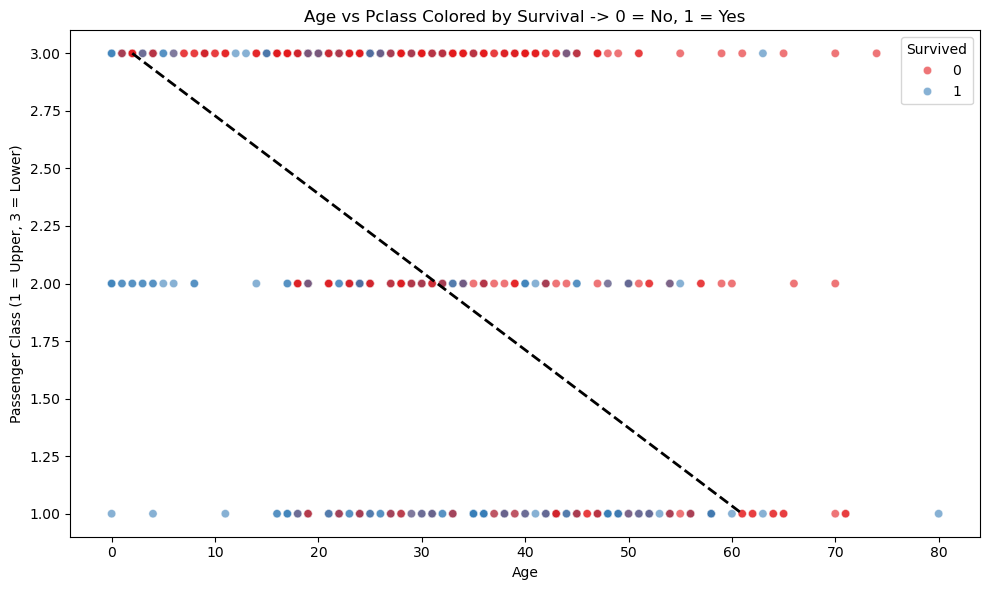

In [8]:
# Create a new figure and axis to avoid overlapping previous plots (optional but good practice)
plt.figure(figsize=(10, 6))

# Scatterplot: visualize Age vs Pclass, with color indicating survival (0 = did not survive, 1 = survived)
sns.scatterplot(
    x="Age",
    y="Pclass",
    hue="Survived",
    data=df_train[["Age", "Pclass", "Survived"]],
    palette="Set1",  # Optional: clearer color palette
    alpha=0.6,  # Optional: slight transparency for overlapping points
)

# Lineplot: draw a line to represent a visual "boundary" or trend
# This line goes from Age=2.0, Pclass=3.0 to Age=61.0, Pclass=1.0
sns.lineplot(
    x=np.array([2.0, 61.0]),
    y=np.array([3.0, 1.0]),
    color="black",  # Make the line stand out
    linestyle="--",  # Dashed line style
    linewidth=2,  # Thicker line
)

# Add labels and title for clarity
plt.title("Age vs Pclass Colored by Survival -> 0 = No, 1 = Yes")
plt.xlabel("Age")
plt.ylabel("Passenger Class (1 = Upper, 3 = Lower)")
plt.legend(title="Survived")

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
# create features
X_train = df_train[["Age", "Pclass"]]
y_train = df_train["Survived"]
X_test  = df_test[["Age", "Pclass"]]
y_test = df_test["Survived"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((755, 2), (755,), (134, 2), (134,))

## Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [10]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc_log = round(model.score(X_train, y_train) * 100, 2)
acc_log
# score - відсоток правильних відповідей класифікатора

69.4

In [11]:
# Обчислюємо точність на тесті
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {round(test_accuracy * 100, 2)}%")

Test Accuracy: 72.39%


In [12]:
model.coef_, model.intercept_

(array([[-0.0464081 , -1.19343869]]), array([3.60349275]))

In [13]:
model.intercept_.item()

3.603492745569915

In [14]:
# f(x_1, x_2) = 0

# x_1*model.coef_[0][0] + x_2*model.coef_[0][1] + model.intercept_.item() = 0
# x_1*model.coef_[0][0] + x_2*model.coef_[0][1] = - model.intercept_.item()
# x_1*(-0.0464081) = - (x_2*(-1.19343869)) - 3.603492745569915

# when x_1 = 0:
# x_2*1.19343869 - 3.603492745569915 = 0
# x_2*1.19343869 = 3.603492745569915
x_2_when_x_1_0 = 3.603492745569915/1.19343869
x_2_when_x_1_0

3.019420080615884

In [15]:
# when x_2 = 0:
#x_1*-0.0464081 = -3.603492745569915
x_1_when_x_2_0 = -3.603492745569915/-0.0464081
x_1_when_x_2_0

77.64792666732563

<Axes: xlabel='Age', ylabel='Pclass'>

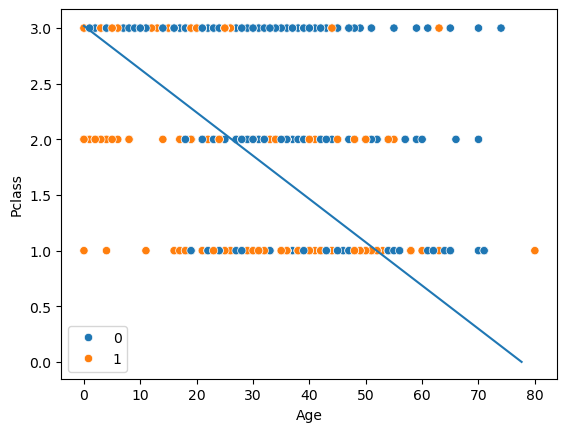

In [16]:
sns.scatterplot(x='Age', y='Pclass', hue="Survived", data=df_train[["Age", "Pclass", "Survived"]])
sns.lineplot(x=np.array([0.0, x_1_when_x_2_0]), y=np.array([x_2_when_x_1_0, 0.0]))
#sns.lineplot(x=np.array([2.0, 44.0]), y=np.array([3.0, 1.0]))
#sns.lineplot(x=np.array([2.0, 61.0]), y=np.array([3.0, 1.0]))

In [17]:
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ["Feature"]
coeff_df["Covariation"] = pd.Series(model.coef_[0])

coeff_df.sort_values(by="Covariation", ascending=False)

,Feature,Covariation
0,Age,-0.046408
1,Pclass,-1.193439


In [18]:
# Кореляція всіх числових ознак з Survived
correlation = df_train.corr(numeric_only=True)["Survived"].sort_values(ascending=False)
print(correlation)

Survived    1.000000
Sex         0.533187
Fare        0.244274
Embarked    0.094931
Parch       0.072032
SibSp      -0.044677
Age        -0.063430
Pclass     -0.326510
Name: Survived, dtype: float64


In [19]:
# add more features
X_train_df = df_train.drop("Survived", axis=1)
X_train = X_train_df.to_numpy()
y_train = df_train["Survived"]
X_test_df = df_test.drop("Survived", axis=1)
X_test  = df_test.drop("Survived", axis=1).to_numpy()
y_test = df_test["Survived"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((755, 7), (755,), (134, 7), (134,))

In [20]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc_log = round(model.score(X_train, y_train) * 100, 2)
acc_log
# score - відсоток правильних відповідей класифікатора

80.4

In [21]:
# x_1*model.coef_[0][0] + x_2*model.coef_[0][1] + x_3*model.coef_[0][2] + ... + model.intercept_.item() = 0

In [22]:
coeff_df = pd.DataFrame(X_train_df.columns)
coeff_df.columns = ['Feature']
coeff_df["Covariation"] = pd.Series(model.coef_[0])

coeff_df.sort_values(by='Covariation', ascending=False)

,Feature,Covariation
1,Sex,2.539042
6,Embarked,0.196484
5,Fare,0.001283
4,Parch,-0.043163
2,Age,-0.047143
3,SibSp,-0.365092
0,Pclass,-1.247458


In [23]:
# take one test example
for feature_name, feature in zip(X_test_df.columns, X_test[0]):
    print(feature_name, feature)

Pclass 3.0
Sex 0.0
Age 28.0
SibSp 0.0
Parch 0.0
Fare 7.8542
Embarked 0.0


In [24]:
model.predict(X_test)

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0])

In [25]:
# take another test example
for feature_name, feature in zip(X_train_df.columns, X_test[1]):
    print(feature_name, feature)

Pclass 1.0
Sex 1.0
Age 14.0
SibSp 1.0
Parch 2.0
Fare 120.0
Embarked 0.0


In [26]:
# probabilities
model.predict_proba(X_test)

array([[0.89928566, 0.10071434],
       [0.03927269, 0.96072731],
       [0.30038276, 0.69961724],
       [0.73682617, 0.26317383],
       [0.03482768, 0.96517232],
       [0.8950408 , 0.1049592 ],
       [0.68865114, 0.31134886],
       [0.86509542, 0.13490458],
       [0.09564956, 0.90435044],
       [0.04422009, 0.95577991],
       [0.58730777, 0.41269223],
       [0.45425994, 0.54574006],
       [0.96354832, 0.03645168],
       [0.90509495, 0.09490505],
       [0.90329333, 0.09670667],
       [0.89756747, 0.10243253],
       [0.68431015, 0.31568985],
       [0.86981726, 0.13018274],
       [0.77862032, 0.22137968],
       [0.89041357, 0.10958643],
       [0.72035506, 0.27964494],
       [0.05909465, 0.94090535],
       [0.9474384 , 0.0525616 ],
       [0.46246141, 0.53753859],
       [0.89039426, 0.10960574],
       [0.50953278, 0.49046722],
       [0.75325965, 0.24674035],
       [0.09289527, 0.90710473],
       [0.5068014 , 0.4931986 ],
       [0.69934328, 0.30065672],
       [0.

In [27]:
# prob - see formula
# prob = 1 / (1 + math.e**-z)
import math

math.e

2.718281828459045

In [28]:
z = 1
1 / (1 + math.e**z)

0.2689414213699951

In [29]:
z = 2
1 / (1 + math.e**z)

0.11920292202211757

In [30]:
z = 3
1 / (1 + math.e**z)

0.04742587317756679

In [31]:
z = -1
1 / (1 + math.e**z)

0.7310585786300049

In [32]:
z = -2
1 / (1 + math.e**z)

0.8807970779778823

In [33]:
z = -3
1 / (1 + math.e**z)

0.9525741268224331

In [34]:
math.e**-1  # inverse
1 / math.e

0.36787944117144233

In [35]:
math.e**-2  # inverse
# 1 / math.e / math.e  
1 / (math.e * math.e)

0.1353352832366127

In [36]:
z = -10
math.e**-z

22026.465794806703

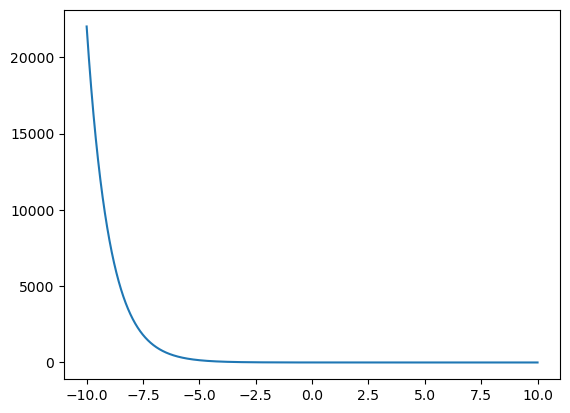

In [37]:
x = np.linspace(-10, 10, 100000)
y = math.e**-x
 
fig = plt.figure()
# Create the plot
plt.plot(x, y)

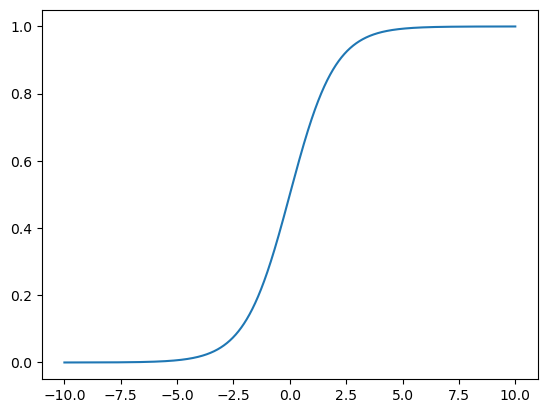

In [38]:
x = np.linspace(-10, 10, 100000)
y = 1 / (1 + math.e**-x)
 
fig = plt.figure()
# Create the plot
plt.plot(x, y)

In [39]:
#y = 1 / (math.e**-1 + 1)
y = 1 / (math.e**5.0 + 1)

y

0.006692850924284857

In [40]:
# Loss function

probs = model.predict_proba(X_test)
probs

array([[0.89928566, 0.10071434],
       [0.03927269, 0.96072731],
       [0.30038276, 0.69961724],
       [0.73682617, 0.26317383],
       [0.03482768, 0.96517232],
       [0.8950408 , 0.1049592 ],
       [0.68865114, 0.31134886],
       [0.86509542, 0.13490458],
       [0.09564956, 0.90435044],
       [0.04422009, 0.95577991],
       [0.58730777, 0.41269223],
       [0.45425994, 0.54574006],
       [0.96354832, 0.03645168],
       [0.90509495, 0.09490505],
       [0.90329333, 0.09670667],
       [0.89756747, 0.10243253],
       [0.68431015, 0.31568985],
       [0.86981726, 0.13018274],
       [0.77862032, 0.22137968],
       [0.89041357, 0.10958643],
       [0.72035506, 0.27964494],
       [0.05909465, 0.94090535],
       [0.9474384 , 0.0525616 ],
       [0.46246141, 0.53753859],
       [0.89039426, 0.10960574],
       [0.50953278, 0.49046722],
       [0.75325965, 0.24674035],
       [0.09289527, 0.90710473],
       [0.5068014 , 0.4931986 ],
       [0.69934328, 0.30065672],
       [0.

In [41]:
1 - 0.89931387

0.10068613000000004

In [42]:
probs_1 = probs[:, 1]
probs_1

array([0.10071434, 0.96072731, 0.69961724, 0.26317383, 0.96517232,
       0.1049592 , 0.31134886, 0.13490458, 0.90435044, 0.95577991,
       0.41269223, 0.54574006, 0.03645168, 0.09490505, 0.09670667,
       0.10243253, 0.31568985, 0.13018274, 0.22137968, 0.10958643,
       0.27964494, 0.94090535, 0.0525616 , 0.53753859, 0.10960574,
       0.49046722, 0.24674035, 0.90710473, 0.4931986 , 0.30065672,
       0.58445372, 0.7450848 , 0.10960574, 0.5414936 , 0.03671903,
       0.39515128, 0.70511994, 0.69413623, 0.13039845, 0.10960574,
       0.14589764, 0.53149796, 0.33191551, 0.10958643, 0.51168222,
       0.49151901, 0.78692815, 0.11901706, 0.22826915, 0.90622608,
       0.92584018, 0.76260585, 0.12937145, 0.11527557, 0.90687988,
       0.88541762, 0.42802464, 0.06251479, 0.16495067, 0.26255213,
       0.33664174, 0.48747156, 0.77798256, 0.16500076, 0.83858352,
       0.38608054, 0.03819108, 0.106511  , 0.90122795, 0.96472137,
       0.29150055, 0.97819079, 0.6898411 , 0.10516283, 0.40606

In [ ]:
# Binary cross entropy: https://www.analyticsvidhya.com/blog/2021/03/binary-cross-entropy-log-loss-for-binary-classification/

In [43]:
condition = probs_1 > 0.5
# probability of survival for surviving group
probs_1[condition]

array([0.96072731, 0.69961724, 0.96517232, 0.90435044, 0.95577991,
       0.54574006, 0.94090535, 0.53753859, 0.90710473, 0.58445372,
       0.7450848 , 0.5414936 , 0.70511994, 0.69413623, 0.53149796,
       0.51168222, 0.78692815, 0.90622608, 0.92584018, 0.76260585,
       0.90687988, 0.88541762, 0.77798256, 0.83858352, 0.90122795,
       0.96472137, 0.97819079, 0.6898411 , 0.78313935, 0.82282994,
       0.57123252, 0.95150332, 0.87962648, 0.7450848 , 0.65365285,
       0.70048297, 0.97528925, 0.52237952, 0.59795797, 0.96794392,
       0.68262772, 0.90080555, 0.56497388, 0.94584747, 0.96110203,
       0.93619711, 0.53753859, 0.88315366, 0.7450848 , 0.82540998])

In [44]:
# probability of survival for non-surviving group
probs_1[~condition]

array([0.10071434, 0.26317383, 0.1049592 , 0.31134886, 0.13490458,
       0.41269223, 0.03645168, 0.09490505, 0.09670667, 0.10243253,
       0.31568985, 0.13018274, 0.22137968, 0.10958643, 0.27964494,
       0.0525616 , 0.10960574, 0.49046722, 0.24674035, 0.4931986 ,
       0.30065672, 0.10960574, 0.03671903, 0.39515128, 0.13039845,
       0.10960574, 0.14589764, 0.33191551, 0.10958643, 0.49151901,
       0.11901706, 0.22826915, 0.12937145, 0.11527557, 0.42802464,
       0.06251479, 0.16495067, 0.26255213, 0.33664174, 0.48747156,
       0.16500076, 0.38608054, 0.03819108, 0.106511  , 0.29150055,
       0.10516283, 0.40606489, 0.14621109, 0.07445062, 0.38892337,
       0.17179843, 0.15417925, 0.05469636, 0.33191551, 0.11418805,
       0.10960574, 0.08861603, 0.12929257, 0.08127633, 0.11582248,
       0.10958643, 0.2195206 , 0.18817386, 0.15417925, 0.11416209,
       0.08492532, 0.07301103, 0.0523412 , 0.15306306, 0.13487026,
       0.14068525, 0.04367728, 0.11231764, 0.10658252, 0.10342

In [45]:
# probability of non-survival for non-surviving group
1 - probs_1[~condition]

array([0.89928566, 0.73682617, 0.8950408 , 0.68865114, 0.86509542,
       0.58730777, 0.96354832, 0.90509495, 0.90329333, 0.89756747,
       0.68431015, 0.86981726, 0.77862032, 0.89041357, 0.72035506,
       0.9474384 , 0.89039426, 0.50953278, 0.75325965, 0.5068014 ,
       0.69934328, 0.89039426, 0.96328097, 0.60484872, 0.86960155,
       0.89039426, 0.85410236, 0.66808449, 0.89041357, 0.50848099,
       0.88098294, 0.77173085, 0.87062855, 0.88472443, 0.57197536,
       0.93748521, 0.83504933, 0.73744787, 0.66335826, 0.51252844,
       0.83499924, 0.61391946, 0.96180892, 0.893489  , 0.70849945,
       0.89483717, 0.59393511, 0.85378891, 0.92554938, 0.61107663,
       0.82820157, 0.84582075, 0.94530364, 0.66808449, 0.88581195,
       0.89039426, 0.91138397, 0.87070743, 0.91872367, 0.88417752,
       0.89041357, 0.7804794 , 0.81182614, 0.84582075, 0.88583791,
       0.91507468, 0.92698897, 0.9476588 , 0.84693694, 0.86512974,
       0.85931475, 0.95632272, 0.88768236, 0.89341748, 0.89657

https://www.mathsisfun.com/algebra/logarithms.html

# 📘 Logistic Regression: Log-Likelihood & Binary Cross-Entropy

## 🔢 1. General Likelihood

Let:

- $\hat{y}^{(i)}$ — predicted probability that the example belongs to class 1  
- $\hat{y}{(i)} \in \{0, 1\}$ — actual class label (0 or 1)

Then the total likelihood of the model making correct predictions on the dataset is:

$$
P(X) = \prod_{i=1}^{m} \left( \hat{y}^{(i)} \right)^{y^{(i)}} \cdot \left( 1 - \hat{y}^{(i)} \right)^{1 - y^{(i)}}
$$

---

## 🧮 2. Log-Likelihood

To avoid numerical underflow (due to multiplying many small probabilities), take the natural logarithm:

$$
\ln(P(X)) = \sum_{i=1}^{m^+} \ln\left( \hat{y}^{(i)} \right) + \sum_{i=1}^{m^-} \ln\left( 1 - \hat{y}^{(i)} \right)
$$

$$
\log P(X) = \sum_{i=1}^{m} \left[ y^{(i)} \cdot \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \cdot \log(1 - \hat{y}^{(i)}) \right]
$$

This is called the **log-likelihood**.

---

## ❌ 3. Loss Function — Negative Log-Likelihood

In practice, we minimize the negative log-likelihood, which becomes the **binary cross-entropy loss**:

$$
\mathcal{L} = - \sum_{i=1}^{m} \left[ y^{(i)} \cdot \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \cdot \log(1 - \hat{y}^{(i)}) \right]
$$


In [49]:
# probability of survival for surviving group * probability of non-survival for non-surviving group
(np.prod(probs_1[condition]))*(np.prod(1 - probs_1[~condition]))

np.float64(1.520169188986794e-14)

In [71]:
-(np.sum(np.log(probs_1[condition])))+(np.sum(np.log(1 - probs_1[~condition])))

np.float64(-5.388910529486374)

In [51]:
y_test_array = y_test.to_numpy()
y_test_array

array([0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0])

In [73]:
probs[0][1]*0

np.float64(0.0)

In [52]:
probs[1][1]*1

np.float64(0.9607273107802655)

In [75]:
condition

array([False,  True,  True, False,  True, False, False, False,  True,
        True, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
        True, False, False,  True,  True, False,  True, False, False,
        True,  True, False, False, False,  True, False, False,  True,
       False,  True, False, False,  True,  True,  True, False, False,
        True,  True, False, False, False, False, False, False,  True,
       False,  True, False, False, False,  True,  True, False,  True,
        True, False, False,  True, False, False,  True,  True, False,
        True,  True,  True, False, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False,  True,  True, False, False, False,  True,  True,
       False, False, False,  True, False,  True, False, False, False,
       False,  True, False, False,  True, False, False,  True,  True,
        True,  True,

In [74]:
condition[0]

np.False_

In [53]:
condition[1]

np.True_

In [76]:
(1-0)*probs[0][1]

np.float64(0.10071434322592744)

### Binary Cross-Entropy Loss (Negative Log-Likelihood)
$$
- \sum_{i=1}^m \left[ y^{(i)} \log \left( \hat{p}^{(i)} \right) + (1 - y^{(i)}) \log \left( 1 - \hat{p}^{(i)} \right) \right]
$$

In [55]:
# rewrite the formula
-np.sum(y_test_array*np.log(probs)[:, 1] + (1 - y_test_array)*(np.log(1 - (probs)[:, 1])))

np.float64(56.3592437202921)

### Average Binary Cross-Entropy Loss Using Both Classes

$$
\mathcal{L} = - \frac{1}{m} \sum_{i=1}^m \left[ y^{(i)} \log \left( \hat{p}_1^{(i)} \right) + (1 - y^{(i)}) \log \left( \hat{p}_0^{(i)} \right) \right]
$$

In [72]:
# probability of survival for surviving group + probability of non-survival for non-surviving group
-np.sum(y_test_array*np.log(probs)[:, 1] + (1 - y_test_array)*np.log(probs)[:, 0]) / len(probs)

np.float64(0.420591371046956)

In [57]:
from sklearn.metrics import log_loss
log_loss(y_test, probs)#, normalize=False)

0.420591371046956

In [58]:
# probability of non-survival for non-surviving group
#y_test_array*np.log(probs)[:, 1]

In [59]:
# probability of non-survival for non-surviving group
(1-y_test.to_numpy())*(1-np.log(probs)[:, 1])

array([3.29546705, 0.        , 0.        , 2.33494053, 0.        ,
       0.        , 2.16684126, 3.00318754, 0.        , 0.        ,
       1.88505318, 0.        , 4.31176765, 3.35487836, 3.33607295,
       3.27855095, 2.15299505, 3.03881614, 2.50787605, 3.21104176,
       2.27423455, 0.        , 3.94576945, 1.62075473, 3.21086555,
       1.71239684, 2.39941871, 0.        , 1.70684335, 2.20178614,
       0.        , 0.        , 3.21086555, 1.61342403, 4.30446018,
       1.92848659, 0.        , 0.        , 3.0371605 , 3.21086555,
       2.92484998, 1.63205591, 2.10287483, 3.21104176, 0.        ,
       0.        , 1.23961833, 3.12848846, 2.47722987, 0.        ,
       0.        , 0.        , 3.04506755, 3.16042973, 0.        ,
       0.        , 1.84857452, 3.77235218, 2.80210882, 2.33730564,
       0.        , 1.71852333, 0.        , 2.80180521, 0.        ,
       1.95170927, 4.26515318, 3.239507  , 0.        , 0.        ,
       2.23271338, 1.02205055, 1.371294  , 0.        , 0.     

In [60]:
# Logarithms: https://www.mathsisfun.com/algebra/logarithms.html
math.log(8, 2)

3.0

In [61]:
math.e ** 2.0794

7.999667673464062

In [62]:
math.log(8, math.e) == math.log(8)

True

## Other classification models

In [63]:
# Stochastic Gradient Descent

sgd = SGDClassifier(loss="log_loss")  # logistic regression
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd
# score - відсоток правильних відповідей класифікатора

73.64

Gradient Descent
![gradient_descent](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*N5WjbzwsCFse-KPjBWZZ6g.jpeg)
![gradient_descent_complex](https://miro.medium.com/v2/resize:fit:900/format:webp/1*jeMxJLZz-o5xniDMKqcTAg.jpeg)

In [64]:
probs_sgd = sgd.predict_proba(X_test)
log_loss(y_test, probs_sgd)

10.571482313722598

In [65]:
# RidgeClassifier
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier()
ridge.fit(X_train, y_train)
Y_pred = ridge.predict(X_test)
acc_ridge = round(ridge.score(X_train, y_train) * 100, 2)
acc_ridge

79.87

## Multi-class classification

In [66]:
# Стратегія "один проти всіх"
from sklearn.multiclass import OneVsRestClassifier
# create features
X_train = df_train[["Age", "Survived"]]
y_train = df_train["Pclass"]
X_test  = df_test[["Age", "Survived"]]
y_test = df_test["Pclass"]

clf = OneVsRestClassifier(LogisticRegression(random_state=0)).fit(X_train, y_train)
preds_3 = clf.predict(X_test)
preds_3

array([3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3,
       3, 3])

In [67]:
y_test.to_numpy()

array([3, 1, 3, 2, 1, 3, 2, 3, 1, 1, 2, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 1,
       3, 1, 3, 1, 2, 2, 1, 2, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 2, 3, 2, 3,
       1, 1, 2, 3, 2, 1, 2, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 1, 3, 2, 2,
       3, 3, 1, 1, 2, 1, 3, 3, 3, 2, 3, 3, 3, 1, 3, 1, 2, 3, 2, 3, 3, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 3, 2, 3, 3, 1, 3, 3,
       3, 1, 3, 1, 3, 3, 2, 2, 3, 3, 2, 1, 3, 3, 1, 1, 1, 1, 3, 1, 2, 2,
       2, 3])

In [68]:
"Train", clf.score(X_train, y_train), "Test", clf.score(X_test, y_test)

('Train', 0.6556291390728477, 'Test', 0.6119402985074627)

In [69]:
# Стратегія "один проти одного"

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

clf = OneVsOneClassifier(
    LogisticRegression(random_state=0)).fit(X_train, y_train)

preds_3 = clf.predict(X_test)
preds_3

array([3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3,
       3, 3])

In [70]:
"Train", clf.score(X_train, y_train), "Test", clf.score(X_test, y_test)

('Train', 0.6569536423841059, 'Test', 0.6119402985074627)